# Qiita

* 対象データ
  * 期間: TODO
  * 内容: 記事データ（item）※本文（body）は除く
  * 取得方法: API経由 TODO
  
## バズる記事とは？

バズる記事の定義

* コメント数（comments_count）の多い記事
  * かついいね数（likes_count）が多い: 良い意味でバズった or 良記事
  * かついいね数（likes_count）が少ない: 悪い意味でバズった or 荒れた記事 or （自分のメモ代わりにしている人）
  
## 参考資料

* Qiita: [お前らの記事のタイトルは間違っている〜爆速で誰でもできるQiitaでバズらせる6個の必殺技まとめ](https://qiita.com/SugarShootingStar/items/bba0fab1e55936e7234a)

In [74]:
import numpy as np
import pandas as pd

from pandas_summary import DataFrameSummary

import matplotlib.pyplot as plt
%matplotlib inline

import pymc3 as pm

import collections
import string

In [3]:
df = pd.read_csv('input/summary.csv')

データの形

* カラム数: 10
* レコード数: 87990

In [4]:
print("カラム数: {}".format(df.shape[1]))
print("レコード数: {}".format(df.shape[0]))

カラム数: 10
レコード数: 87990


カラム一覧

In [5]:
for c in df.columns:
    print(c)

title
id
created_at
updated_at
likes_count
comments_count
tags_str
user_id
user_permanent_id
url


In [6]:
df.head(3).T

,0,1,2
title,DynamoDB ローカルでチュートリアル,C++で初めてのゲーム開発する時に、気をつけて欲しいこと,LSTMの簡易まとめ
id,022f5c5b4e45f42727e9,1b7ab644e7de7709b073,636ec5e15df4e57f78a0
created_at,2017-12-31T08:54:37+09:00,2017-12-31T08:39:29+09:00,2017-12-31T08:32:55+09:00
updated_at,2017-12-31T08:54:37+09:00,2017-12-31T14:21:16+09:00,2018-01-04T11:16:21+09:00
likes_count,1,35,2
comments_count,0,0,0
tags_str,"AWS,チュートリアル,DynamoDB",C++,"機械学習,深層学習,LSTM,TensorFlow"
user_id,h2m_kinoko,4_mio_11,matsui-k20xx
user_permanent_id,119864,36899,214997
url,https://qiita.com/h2m_kinoko/items/022f5c5b4e4...,https://qiita.com/4_mio_11/items/1b7ab644e7de7...,https://qiita.com/matsui-k20xx/items/636ec5e15...


# EDA

要約統計量

In [7]:
DataFrameSummary(df).summary()

,title,id,created_at,updated_at,likes_count,comments_count,tags_str,user_id,user_permanent_id,url
count,NaN,NaN,NaN,NaN,87990,87990,NaN,NaN,87990,NaN
mean,NaN,NaN,NaN,NaN,8.14695,0.319536,NaN,NaN,147979,NaN
std,NaN,NaN,NaN,NaN,58.1444,1.69247,NaN,NaN,88418.7,NaN
min,NaN,NaN,NaN,NaN,0,0,NaN,NaN,29,NaN
25%,NaN,NaN,NaN,NaN,0,0,NaN,NaN,65978,NaN
50%,NaN,NaN,NaN,NaN,1,0,NaN,NaN,148882,NaN
75%,NaN,NaN,NaN,NaN,4,0,NaN,NaN,227518,NaN
max,NaN,NaN,NaN,NaN,3583,104,NaN,NaN,322336,NaN
counts,87990,87990,87990,87990,87990,87990,87990,87990,87990,87990
uniques,87815,87990,87815,87825,603,54,54919,21091,21091,87990


## コメント数といいね数

コメント数の分布

(array([8.7699e+04, 2.1300e+02, 3.7000e+01, 2.3000e+01, 7.0000e+00,
        6.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 3.0000e+00]),
 array([  0. ,  10.4,  20.8,  31.2,  41.6,  52. ,  62.4,  72.8,  83.2,
         93.6, 104. ]),
 <a list of 10 Patch objects>)

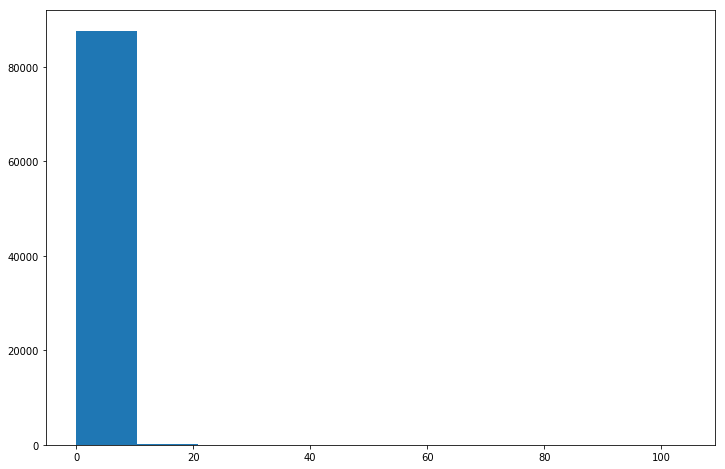

In [8]:
plt.figure(figsize=(12, 8))
plt.hist(df['comments_count'])

コメントが0の割合

* コメント0の記事は全体の約89%

In [9]:
print("{:.2f}%".format(len(df[df['comments_count']==0]) / len(df) * 100))

89.24%


コメント数の分布がエグいの対数変換してみる

* 対数変換してもかなり偏った分布になる

(array([7.8521e+04, 3.0370e+03, 4.4260e+03, 1.0770e+03, 5.6800e+02,
        2.1300e+02, 8.8000e+01, 4.0000e+01, 1.5000e+01, 5.0000e+00]),
 array([0.        , 0.46539604, 0.93079207, 1.39618811, 1.86158414,
        2.32698018, 2.79237621, 3.25777225, 3.72316828, 4.18856432,
        4.65396035]),
 <a list of 10 Patch objects>)

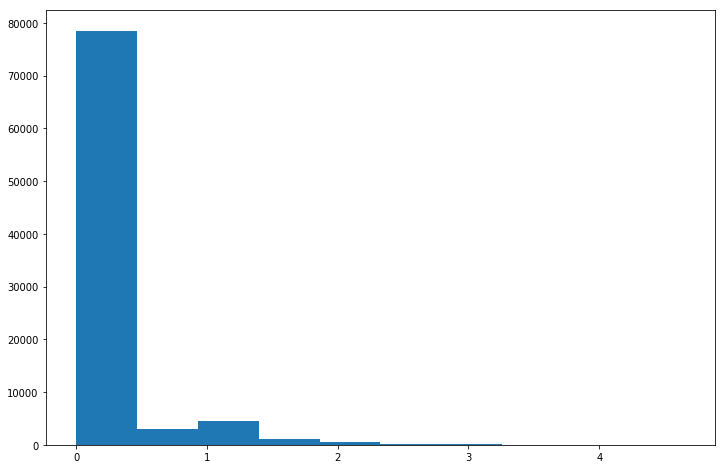

In [10]:
plt.figure(figsize=(12, 8))
plt.hist(np.log(df['comments_count'].values+1))

いいね数の分布

(array([8.7635e+04, 2.2500e+02, 6.4000e+01, 3.8000e+01, 1.6000e+01,
        6.0000e+00, 4.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([   0. ,  358.3,  716.6, 1074.9, 1433.2, 1791.5, 2149.8, 2508.1,
        2866.4, 3224.7, 3583. ]),
 <a list of 10 Patch objects>)

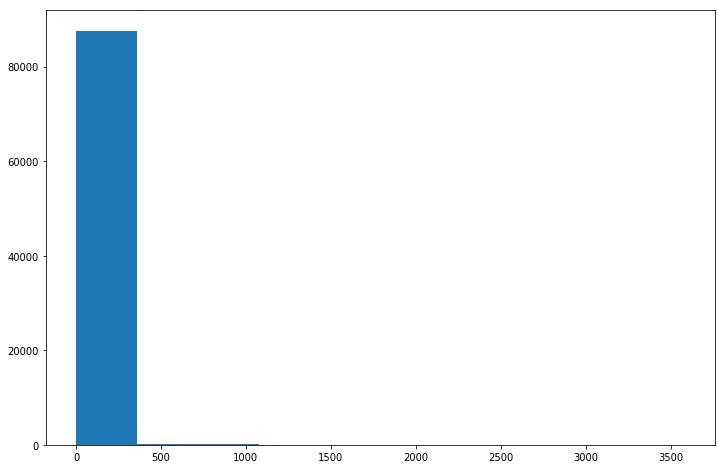

In [11]:
plt.figure(figsize=(12, 8))
plt.hist(df['likes_count'])

いいねが0の割合

* いいね0の記事は全体の約32%

In [12]:
print("{:.2f}%".format(len(df[df['likes_count']==0]) / len(df) * 100))

31.65%


いいね数の分布もエグいの対数変換してみる

* 対数変換するとコメント数の対数分布よりはましになる

(array([4.6195e+04, 2.2701e+04, 1.1175e+04, 4.9110e+03, 1.5020e+03,
        6.8100e+02, 4.0800e+02, 2.8200e+02, 1.1500e+02, 2.0000e+01]),
 array([0.        , 0.81842348, 1.63684695, 2.45527043, 3.27369391,
        4.09211739, 4.91054086, 5.72896434, 6.54738782, 7.3658113 ,
        8.18423477]),
 <a list of 10 Patch objects>)

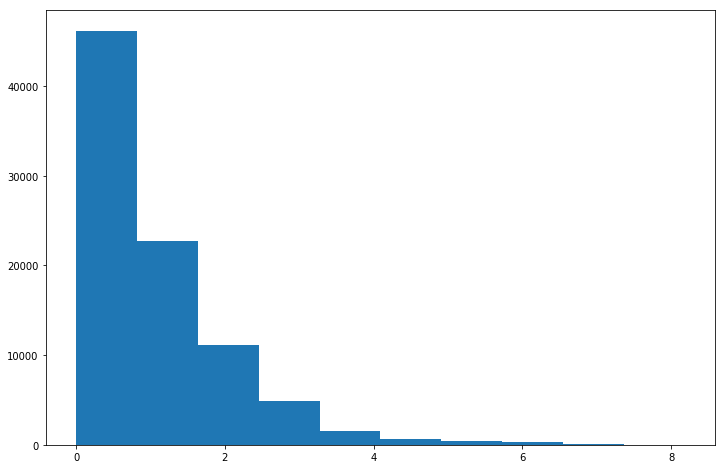

In [13]:
plt.figure(figsize=(12, 8))
plt.hist(np.log(df['likes_count'].values+1))

## コメント数の詳細

コメントありの記事だけ抽出

In [14]:
df_with_comments = df[df['comments_count']>0]
print("count: {}".format(len(df_with_comments)))

count: 9469


コメント数が多い記事のTop20

* コメント数が多いといっていいね数が多いわけではない（コメント数は多いがいいね数が少ない記事が割とある）
  * メモ代わりに自分でコメントしている
  * 一部の人が会話している（多くの人が興味を持つ話題ではない）
  * 記事内のコードに不具合がありコメントでやり取りして長引いている（GitHubのissue使った方がいいと思う）

In [15]:
df_with_comments.sort_values(by='comments_count', ascending=False)[[
    "title",
    "tags_str",
    "comments_count",
    "likes_count",
    "url"
]].head(20)

,title,tags_str,comments_count,likes_count,url
71463,「ゴミ記事が多すぎる問題」に対する私見,"ポエム,アウトプット",104,852,https://qiita.com/akira_/items/c8881dcde93d4cb...
68243,オブジェクト指向が5000%理解できる記事,オブジェクト指向,102,1463,https://qiita.com/it-hero/items/b2f8e39d7cc23a...
80049,全ての開発者がQiitaへのアウトプットをやめるべき理由,"Qiita,ポエム,キャリア,エンジニア,アウトプット",100,320,https://qiita.com/qiitadaisuki/items/2160a390c...
34628,Windows への OpenPose導入手順【7/7追記】,"Windows,OpenPose",90,30,https://qiita.com/miu200521358/items/539aaa63f...
5663,JavaScriptにSchemeを実装する,"JavaScript,Scheme,lisp,言語作成",89,16,https://qiita.com/tutinoco/items/f22f4005703e0...
30368,Java初心者時代にコードレビューで指摘された悪しき習慣,"Java,悪い見本,コードレビュー,新人プログラマ応援",62,964,https://qiita.com/gengogo5/items/5b038cf0b4034...
20415,Laravelの開発環境を仮想マシン上に構築してVueのサンプルを動かしてみる,"npm,SPA,vue,vue-router,laravel5.5",61,1,https://qiita.com/kenyuasa/items/b7be72823b353...
79197,報酬がQiitaを阻害する「アンダーマイニング効果」（人間とは、かくもヘンテコな生きものなり）,"Qiita,UX,ポエム,心理学,エンジニア",60,809,https://qiita.com/youwht/items/1c7ae618c8b2498...
42197,glibc newlib より速いクイックソート(qs9 qs10)、 世界最速をめざして,"sort,アルゴリズム,ソート,クイックソート,qsort",56,1,https://qiita.com/t-kawa/items/99408891b18bd1f...
78400,侍エンジニア塾のC言語のサンプルがヤバすぎる。,C,54,724,https://qiita.com/hamichamp/items/7b7a7ee091a6...


## いいね数の詳細

In [16]:
df_with_likes = df[df['likes_count']>0]
print("count: {}".format(len(df_with_likes)))

count: 60137


いいね数が多い記事のTop20

* いいね数が多い記事は平均してコメントも多い傾向にある

In [17]:
df_with_likes.sort_values(by='likes_count', ascending=False)[[
    "title",
    "tags_str",
    "comments_count",
    "likes_count",
    "url"
]].head(20)

,title,tags_str,comments_count,likes_count,url
1054,イマドキのJavaScriptの書き方2018,JavaScript,45,3583,https://qiita.com/shibukawa/items/19ab5c381bbb...
33967,開設後３週間で収益１０万円を得た個人開発サイトでやったことの全部を公開する,"Ruby,JavaScript,Heroku,AWS,個人開発",37,2686,https://qiita.com/jabba/items/1a49e860a09a613b...
37148,2018年の最先端バックエンドエンジニアに必要なスキルについて考えてみました。,"AWS,gcp,キャリア",15,2487,https://qiita.com/poly_soft/items/fb649573c19b...
69409,[2018] 個人でも使える！おすすめAPI一覧,"Python,Instagram,GoogleCloudPlatform",15,2439,https://qiita.com/mikan3rd/items/ba4737023f08b...
33628,コーディングをするときに鼻血がでるほど便利なwebツールリスト(随時更新予定),"正規表現,Web,tool,coding,naming",18,2404,https://qiita.com/isuke/items/7fcc5eb0b985005b...
65115,Chrome拡張の高速な英語辞書ツールをつくりました(Mouse Dictionary),"JavaScript,Chrome,chrome-extension,English",31,2349,https://qiita.com/wtetsu/items/c43232c6c44918e...
73204,エンジニアは全員技術記事を書くことを習慣化した方がいいぞ,"Qiita,翻訳,アウトプット,新人プログラマ応援",44,2090,https://qiita.com/HiromuMasuda0228/items/a71de...
68548,なぜ我々はいまだに文字列でコメントを書いているのか,"Emacs,SublimeText3,コメント,Visual,VSCode",23,2062,https://qiita.com/tkrkt/items/2fc9a9a59ce679aa...
70338,もっと気軽にアウトプットできる技術ブログサービス「Qrunch（クランチ）」をリリースした【...,"Ruby,Markdown,RubyOnRails,Webサービス,個人開発",34,1952,https://qiita.com/c0domisu/items/95a561d163d26...
10263,【今日からできる】コミットメッセージに 「プレフィックス」 をつけるだけで、開発効率が上がった話,"Git,GitHub,devops,チーム,新人プログラマ応援",33,1947,https://qiita.com/numanomanu/items/45dd285b286...


# 特徴量

* タイトル
  * <font color="red">長さ</font> （たぶん最大250文字。実際にはせいぜい100文字以内が表示的に現実的）
  * 文字種の数
    * <font color="red">数字の数</font>
    * アルファベットの数（大文字・小文字は区別しない）
    * ひらがなの数
    * カタカナの数
    * 漢字の数
    * それ以外の数（記号など）
* タグ
  * タグの数
  * 文字種の数（タイトルと同様）

ちなみに最大文字数のタイトルは239文字

In [18]:
print(max(df["title"], key=len))
print(len(max(df["title"], key=len)))

YYPHP#54「PhpStormの法人ライセンスは1台にしか入れられない？、Laravelでブログを作るには？、Chromeのみ対応のシステムをIE11対応させたいが…、みんながDockerをどんなふうに使っているのか開発のしかたなどを聞きたい、PHPはフランス語に弱い？、前前人者が作ったシステムが良くわからない、型とオブジェクト指向がマイブームで再燃しているのはなぜか？、PhpStormのEAPでコレクション型のジェネリクス表記ができるようになったよ、技術書典５の案内」
239


## モデリング

In [53]:
s = "YYPHP#54「PhpStormの法人ライセンスは1台にしか入れられない？、Laravelでブログを作るには？、Chromeのみ対応のシステムをIE11対応させたいが…、みんながDockerをどんなふうに使っているのか開発のしかたなどを聞きたい、PHPはフランス語に弱い？、前前人者が作ったシステムが良くわからない、型とオブジェクト指向がマイブームで再燃しているのはなぜか？、PhpStormのEAPでコレクション型のジェネリクス表記ができるようになったよ、技術書典５の案内」"

In [54]:
s

'YYPHP#54「PhpStormの法人ライセンスは1台にしか入れられない？、Laravelでブログを作るには？、Chromeのみ対応のシステムをIE11対応させたいが…、みんながDockerをどんなふうに使っているのか開発のしかたなどを聞きたい、PHPはフランス語に弱い？、前前人者が作ったシステムが良くわからない、型とオブジェクト指向がマイブームで再燃しているのはなぜか？、PhpStormのEAPでコレクション型のジェネリクス表記ができるようになったよ、技術書典５の案内」'

In [56]:
c = collections.Counter(s)

In [71]:
2 in [1,2,3]

True

In [76]:
string.ascii_letters

'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [78]:
string.digits

'0123456789'

In [81]:
string.printable

'0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ \t\n\r\x0b\x0c'

In [82]:
["{}:{}".format(k[0], k[1]) for k in c.items() if k[0] in string.digits]

['5:1', '4:1', '1:3']

In [88]:
ds = {k[0]: k[1] for k in c.items() if (k[0] in '０１２３４５６７８９') or (k[0] in string.digits)}

In [92]:
sum(ds.values())

6

In [98]:
def count_digits(s):
    c = collections.Counter(s)
    return {k[0]: k[1] for k in c.items() if (k[0] in '０１２３４５６７８９') or (k[0] in string.digits)}

In [99]:
sum(count_digits(s).values())

6

数字の文字数

In [113]:
digit_lengths = [sum(count_digits(x).values()) for x in df["title"].values]

In [114]:
digit_lengths[:10]

[0, 0, 0, 2, 0, 0, 0, 0, 1, 1]

In [115]:
df["title"].values[:10]

array(['DynamoDB ローカルでチュートリアル', 'C++で初めてのゲーム開発する時に、気をつけて欲しいこと',
       'LSTMの簡易まとめ', 'Mastodonで始めるPythonプログラミング！腕試しテスト50本ノック（初級編）',
       'create-react-appでReactの開発環境を構築する', 'Hyperappを読む',
       'matplotlib の legend(凡例) の 位置を調整する legend bbox_to_anchor loc',
       'ノートンいれたらMacが再起動から復帰しなくなった。(復旧済み)', 'Cloud9上でJupyterを動かせる環境を作ってみた',
       'AWSのEC2を使ってJupyterをブラウザから使えるようにする方法'], dtype=object)

タイトルの文字数

In [116]:
title_lengths = [len(x) for x in df["title"].values]

In [ ]:
model = pm.Model()

with model:
        # define priors, weakly informative Normal
    b0 = pm.Normal('b0', mu=0, sd=10)
    b1 = pm.Normal('b1', mu=0, sd=10)
    b2 = pm.Normal('b2', mu=0, sd=10)

    # define linear model and exp link function
    theta = b0 + b1 * title_lengths + b2 * digit_lengths
    comments = pm.Poisson("comments", mu=np.exp(theta), observed=df["comments_count"].values)

In [125]:
model

In [118]:
with model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b2, b1, b0]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:50<00:00, 79.68draws/s] 
The acceptance probability does not match the target. It is 0.9297559721299519, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9620326035391056, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9370596321766855, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9885538805066855, but should be close to 0.8. Try to increase the number of tuning steps.


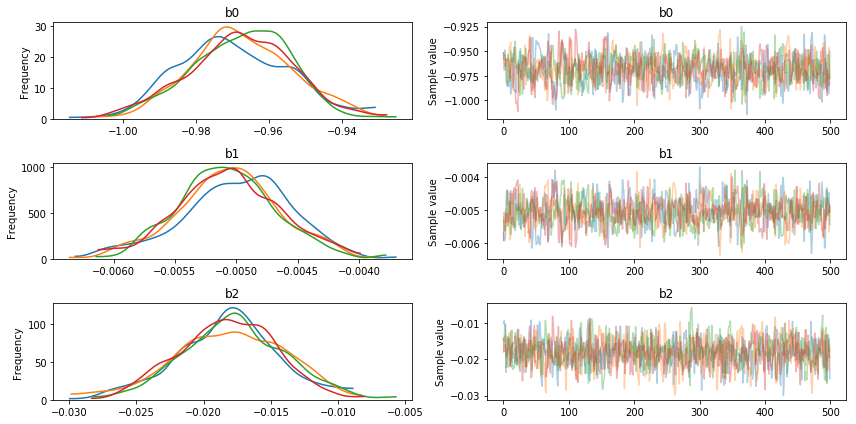

In [121]:
pm.traceplot(trace);

In [128]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
b0,-0.968183,0.014222,0.000489,-0.997547,-0.942268,786.063855,1.002301
b1,-0.005051,0.000421,0.000015,-0.005852,-0.004187,713.667675,1.002599
b2,-0.018104,0.003832,0.000114,-0.025486,-0.010341,1102.958759,1.001500


In [132]:
np.exp(pm.summary(trace))[['mean', 'sd', 'hpd_2.5','hpd_97.5']]

,mean,sd,hpd_2.5,hpd_97.5
b0,0.379773,1.014323,0.368783,0.389743
b1,0.994962,1.000421,0.994166,0.995822
b2,0.982059,1.003839,0.974836,0.989712


sample1

In [138]:
target = "イマドキのJavaScriptの書き方2018"

In [146]:
taget_item = df[df["title"] == target]
taget_item

,title,id,created_at,updated_at,likes_count,comments_count,tags_str,user_id,user_permanent_id,url
1054,イマドキのJavaScriptの書き方2018,19ab5c381bbb2e09d0d9,2017-12-26T14:31:16+09:00,2018-11-17T12:08:09+09:00,3583,45,JavaScript,shibukawa,6105,https://qiita.com/shibukawa/items/19ab5c381bbb...


In [151]:
int(taget_item.comments_count)

45

In [152]:
pred_count = 0.379773 + 0.994962 * len(target) + sum(count_digits(target).values())
print("actual    comments_count: {:.0f}".format(int(taget_item.comments_count)))
print("predicted comments_count: {:.0f}".format(pred_count))

actual    comments_count: 45
predicted comments_count: 27


sample2

In [155]:
target = "毎月 500 時間の社内ルーティンワークを GAS を使って自動化した話"
pred_count = 0.379773 + 0.994962 * len(target) + sum(count_digits(target).values())
print("actual    comments_count: {:.0f}".format(0))
print("predicted comments_count: {:.0f}".format(pred_count))

actual    comments_count: 0
predicted comments_count: 39
